# **A fly in the teleporter**

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
import math
import time
%matplotlib inline

In [3]:
#### CAUTION: This sample is big, and may take several seconds to execute.
####          It may even fail on some smaller devices (e-readers, etc.)

####          To speed it up, you can use the 6-qubit "mini-fly".
####          Just change num_fly_qubits from 8 to 6.
num_fly_qubits = 6 ## this can be 6 or 8, for a mini-fly or full-fly.

In [4]:
## This is the left half of the pixels of the fly,
## encoded as an 8x16 array:
image8 = [ '........',
           '...X....',
           '....X.XX',
           '.....XXX',
           '....XXXX',
           'XX...XXX',
           '..XXX.XX',
           '...X....',
           '..X...XX',
           '.X...XXX',
           'X....XXX',
           'X..XXXXX',
           '.XXX.XXX',
           '...X..XX',
           '..X.....',
           '........']

In [5]:
## This is the left half of the pixels of the fly,
## encoded as a 4x8 array:
image6 = [ '..X.',
           '...X',
           'X.XX',
           '.X..',
           'X..X',
           'X..X',
           '.XX.',
           'X...']

image = image6 if num_fly_qubits == 6 else image8

In [6]:
## This is the classic teleport example, but with an interesting
## payload, and some controllable error.
teleport_error = 0.1   ## <--- change this number to 0.1 or more
do_teleport = True     ## Enables the teleporter

In [7]:
# Set up the program
fly     = QuantumRegister(num_fly_qubits, name='fly')
epair1  = QuantumRegister(num_fly_qubits, name='epair1')
epair2  = QuantumRegister(num_fly_qubits, name='epair2')
scratch = epair1 # We only need scratch qubits during preparation
send0_c = [ClassicalRegister(1, name='send0c'+str(i)) for i in range(num_fly_qubits)]
send1_c = [ClassicalRegister(1, name='send1c'+str(i)) for i in range(num_fly_qubits)]
qc = QuantumCircuit(fly, epair1, epair2, *send0_c, *send1_c)

In [8]:
last_not = 0

In [9]:
def main():
    prepare_fly(fly)
    if do_teleport:
        entangle_pair(epair1, epair2)
        send_payload(fly, epair1, [send0_c, send1_c])
        apply_error(epair2, teleport_error)
        receive_payload(epair2, [send0_c, send1_c])

In [10]:
def entangle_pair(ep1, ep2):
    ## Create all the entangled qubits we need to teleport this object.    
    qc.h(ep1)
    qc.cx(ep1, ep2)
    qc.barrier()

In [11]:
def prepare_fly(fly):
    ## Encode the fly pixels into relative phases in a
    ## quantum superposition
    global last_not
    qc.h(fly)
    for y in range(len(image)):
        for x in range(len(image[0])):
            if (image[y][x] == 'X'):
                pixel(fly, x + 0, y)
    # TODO: translate these lines
    for i in range(num_fly_qubits):
        if (1 << i) & last_not:
            qc.x(fly[i])
    # Reflect to get both halves
    if num_fly_qubits == 8:
        qc.cx(fly[3], fly[0])
        qc.cx(fly[3], fly[1])
        qc.cx(fly[3], fly[2])
    else:
        qc.cx(fly[2], fly[0])
        qc.cx(fly[2], fly[1])

    # Grover to turn the phase diffs into amp diffs
    Grover(fly)

    ## At this point, reading the "fly" register would be very likely
    ## to return the coordinates of one of the pixels in the fly.
    qc.barrier()

In [12]:
def pixel(obj, x, y):
    ## Given x and y, flip the phase of one term
    ## Note: last_not is used to avoid redundant NOT gates
    global last_not
    val = ~((y << (num_fly_qubits >> 1)) | x)
    for i in range(num_fly_qubits):
        if (1 << i) & (val ^ last_not):
            qc.x(obj[i])
    last_not = val
    if num_fly_qubits == 8:
        multi_cz([obj[0], obj[1], obj[2], obj[4], obj[5], obj[6], obj[7]])
    else:
        multi_cz([obj[0], obj[1], obj[3], obj[4], obj[5]])
#    obj.cphase(180, ~0x8) # TODO: Translate this line

In [13]:
def send_payload(payload, ep, digital_bits):
    ## Entangle the payload with half of the e-pair, and then vaporize it!
    qc.cx(payload, ep)
    qc.h(payload)
    for i in range(num_fly_qubits):
        qc.measure(payload[i], digital_bits[0][i])
        qc.measure(ep[i], digital_bits[1][i])
    qc.barrier()

In [14]:
def apply_error(qubits, error_severity):
    ## Apply some unpredictable noise to the system
    qc.rx(error_severity, qubits);
    qc.barrier();

In [15]:
def receive_payload(ep, digital_bits):
    ## Teleport receiver applies the correct operations based on
    ## the digital data. Note that in this example we *could*
    ## use postselection, but would only succeed once every 65,536
    ## tries, on average.
    for i in range(num_fly_qubits):
        qc.x(ep[i]).c_if(digital_bits[1][i], 1)
        qc.z(ep[i]).c_if(digital_bits[0][i], 1)
    qc.barrier()

In [16]:
def Grover(qreg, condition_qubits=None):
    if condition_qubits is None:
        condition_qubits = []
    qc.h(qreg)
    qc.x(qreg)
    multi_cz([x for x in qreg] + condition_qubits)
    qc.x(qreg)
    qc.h(qreg)

In [17]:
def multi_cz(qubits):
    ## This will perform a CCCCCZ on as many qubits as we want,
    ## as long as we have enough scratch qubits
    multi_cx(qubits, do_cz=True)

In [18]:
def multi_cx(qubits, do_cz=False):
    ## This will perform a CCCCCX with as many conditions as we want,
    ## as long as we have enough scratch qubits
    ## The last qubit in the list is the target.
    target = qubits[-1]
    conds = qubits[:-1]
    scratch_index = 0
    ops = []
    while len(conds) > 2:
        new_conds = []
        for i in range(len(conds)//2):
            ops.append((conds[i * 2], conds[i * 2 + 1], scratch[scratch_index]))
            new_conds.append(scratch[scratch_index])
            scratch_index += 1
        if len(conds) & 1:
            new_conds.append(conds[-1])
        conds = new_conds
    for op in ops:
        qc.ccx(op[0], op[1], op[2])
    if do_cz:
        qc.h(target)
    if len(conds) == 0:
        qc.x(target)
    elif len(conds) == 1:
        qc.cx(conds[0], target)
    else:
        qc.ccx(conds[0], conds[1], target)
    if do_cz:
        qc.h(target)
    ops.reverse()
    for op in ops:
        qc.ccx(op[0], op[1], op[2])

main()

In [19]:
## That's the program. Everything below runs and draws it.
## TODO: A nice way to draw the fly here.

backend = BasicAer.get_backend('statevector_simulator')
tic = time.time()
job = execute(qc, backend)
result = job.result()
toc = time.time()
print('Finished in {} seconds'.format(toc - tic))

Finished in 7.393707752227783 seconds


In [20]:
counts = result.get_counts(qc)
print('counts:',counts)

counts: {'0 0 0 1 0 0 1 0 0 1 1 0': 1}


[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
drawing...


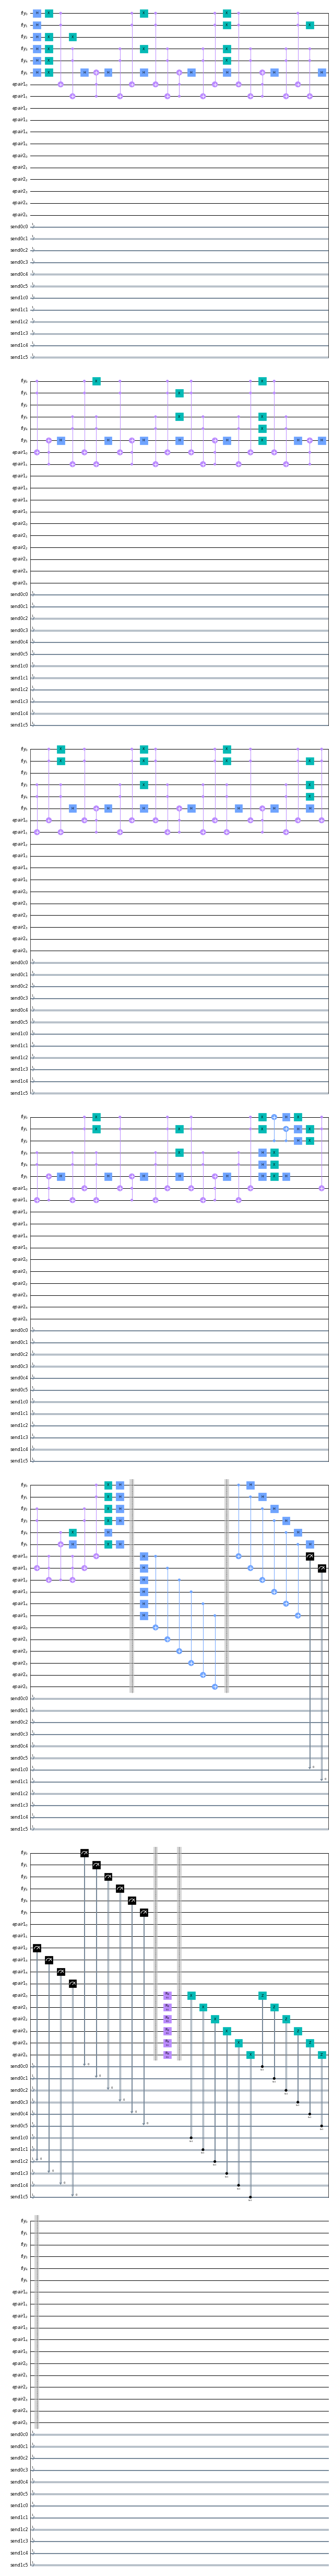

In [21]:
outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)
print('drawing...')
qc.draw(scale=0.5)        # draw the circuit